# Part 1: Image Classification using CNN

## Motivation of Baseline Structure:

I followed along to the tutorial and decide that structuring my model similarly to the tutorial would be a good baseline. For the most part I used the tutorial code with some alterations for this baseline. Since this dataset was given in one image folder with a test and train csv I had to split the train dataset into two parts to get a train and validation dataset. Then i created subfolders based off the labels so that the images were sorted into train, validation, and test folders then in those there were folders for each label. Once i had the images sorted I used the tutorial code with a few changes to implement the baseline cnn.

In [ ]:
#upload file from local system
from google.colab import files
uploades = files.upload()

In [ ]:
shutil.rmtree('./images/')

In [ ]:
! unzip /content/drive/MyDrive/Cmpe351_Datasets/Assignment_2/images.zip

<ipython-input-2-6ecbd58cf645>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pic = imageio.imread('./images/'+ random_pic_file)


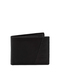

original height, width, and channels of each image: 80 60 3
There are 44441 files in the folder at ./images/


In [2]:
import imageio
import os
import glob
from collections import Counter
import random 
myseed = 12345  # set a random seed for reproducibility

from google.colab.patches import cv2_imshow


# let's take a look at one random image 
random_pic_file = random.choice(os.listdir('./images/'))
pic = imageio.imread('./images/'+ random_pic_file)
cv2_imshow(pic)
height, width, channels = pic.shape
print(f'original height, width, and channels of each image: {height} {width} {channels}')

# let's take a look at label distirbution 
folder_path_options = ["./images/"]
for path in folder_path_options:
  labels = []
  # let's check how many images we have
  files = glob.glob(path+"*")
  file_count = len(files)
  print(f'There are {file_count} files in the folder at {path}')

Images are [3 80 60] in this dataset so I decided to transform them into 60 by 60 instead of 128 by 128 as it is in the tutorial code.

# Set up required libraries and GPU


In [3]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import shutil
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [4]:
# basic setup for PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

Code below splits the train.csv into a train dataset and validation dataset. Also created a test dataset from the test.csv. 

In [5]:
from sklearn.utils import validation
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

trainset_old = pd.read_csv('/content/drive/MyDrive/Cmpe351_Datasets/Assignment_2/train/train.csv')
print("\ntrainset_old:\n")
print(trainset_old.head())
print(trainset_old.shape)

trainset_new, validationset = train_test_split(trainset_old, test_size=0.2)
print("\ntrainset_new:\n")
print(trainset_new.head())
print(trainset_new.shape)

print("\nvalidationset:\n")
print(validationset.head())
print(validationset.shape)

testset = pd.read_csv('/content/drive/MyDrive/Cmpe351_Datasets/Assignment_2/test/test.csv')
print("\ntestset:\n")
print(testset.head())
print(testset.shape)


trainset_old:

   imageid       label                                     productname
0     2653        Bags            Murcia Women Leather Office Grey Bag
1    55997      Others  Colorbar Velvet Matte Temptation Lipstick 24MA
2     2640       Shoes           Carlton London Men Brown Formal Shoes
3    40565     Topwear                            W Women Maroon Kurta
4    38932  Bottomwear               Gini and Jony Girls Pink Leggings
(40441, 3)

trainset_new:

       imageid    label                                        productname
13640     8725  Topwear        Indigo Nation Men Checks Shirt Black Shirts
30798    51154   Others                            Raymond Men Brown Socks
29736    34462     Bags                  ADIDAS Unisex Black Laptop Sleeve
37390    29572    Shoes                Vans Men Classic Slip-On Grey Shoes
22924    13933  Topwear  United Colors of Benetton Women Blue Polo Tshirts
(32352, 3)

validationset:

       imageid       label                           

In [6]:
# Splitting images folder into train, validation, & test folders
# Creating subfolders based off labels

images_folder_path = "./images/"

# Create a dictionary to store the labels and their respective image IDs
labels_dict = {}

# Iterate through the rows of the train, validation, and test DataFrames and populate the dictionary
for df in [trainset_new, validationset, testset]:
    for index, row in df.iterrows():
        image_id = row["imageid"]
        label = row["label"]
        labels_dict.setdefault(label, {"train": [], "val": [], "test": []})
        if df is trainset_new:
            labels_dict[label]["train"].append(image_id)
        elif df is validationset:
            labels_dict[label]["val"].append(image_id)
        else:
            labels_dict[label]["test"].append(image_id)

# Create subfolders for each label in the train, validation, and test folders and move the images into their respective subfolders
for label, split_dict in labels_dict.items():
    for split_name, split_image_ids in split_dict.items():
        split_folder_path = os.path.join(images_folder_path, split_name, label)
        os.makedirs(split_folder_path, exist_ok=True)
        for image_id in split_image_ids:
            image_path = os.path.join(images_folder_path, f"{image_id}.jpg")
            if os.path.isfile(image_path):
                shutil.move(image_path, split_folder_path)

In [7]:
# Checking # of images and comparing to row count from above to make sure images were moved properly

# Path to the folder containing the train, validation, and test subfolders
base_folder_path = "images/"

# Iterate through the train, validation, and test subfolders, and count the number of JPG files in each
for split_name in ["train", "val", "test"]:
    split_folder_path = os.path.join(base_folder_path, split_name)
    print(f"{split_name.capitalize()} split:")
    jpg_count = 0
    for label_name in os.listdir(split_folder_path):
        label_folder_path = os.path.join(split_folder_path, label_name)
        for file_name in os.listdir(label_folder_path):
            if file_name.endswith(".jpg"):
                jpg_count += 1
    print(f"\t{jpg_count} JPG files\n")

Train split:
	32352 JPG files

Val split:
	8089 JPG files

Test split:
	4000 JPG files



In [8]:
# Specify the paths to the train, test, and validation folders
train_folder = "./images/train"
test_folder = "./images/test"
val_folder = "./images/val"

# Define a function to rename the files in a folder
def rename_files(folder_path):
    # Get a list of all JPG files in the folder
    jpg_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]

    # Rename the files
    for i, f in enumerate(jpg_files):
        old_path = os.path.join(folder_path, f)
        new_path = os.path.join(folder_path, str(i) + ".jpg")
        os.rename(old_path, new_path)

# Rename the files in the train folder
for label_folder in os.listdir(train_folder):
    label_folder_path = os.path.join(train_folder, label_folder)
    rename_files(label_folder_path)

# Rename the files in the test folder
for label_folder in os.listdir(test_folder):
    label_folder_path = os.path.join(test_folder, label_folder)
    rename_files(label_folder_path)

# Rename the files in the validation folder
for label_folder in os.listdir(val_folder):
    label_folder_path = os.path.join(val_folder, label_folder)
    rename_files(label_folder_path)

# Preparing dataset




Resized the images into 60 by 60.

In [9]:
# All we need here is to resize the PIL image and transform it into Tensor.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 60)
    transforms.Resize((60, 60)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.Resize((60, 60)),
    transforms.ToTensor(),
])

# Dataset

Similar to the food dataset class the FashionItemDataset links an image to its corresponding label.

In [10]:
from sklearn.preprocessing import LabelEncoder

class FashionItemDataset(Dataset):
    def __init__(self, path, tfm=test_tfm, files=None):
        self.path = path
        self.transform = tfm
        self.files = []
        self.labels = []
        self.label_map = {}

        for label in os.listdir(path):
            label_path = os.path.join(path, label)
            if os.path.isdir(label_path):
                for fname in os.listdir(label_path):
                    if fname.endswith('.jpg'):
                        self.files.append(os.path.join(label_path, fname))
                        self.labels.append(label)
                        self.label_map[os.path.join(label_path, fname)] = label

        self.num_classes = len(set(self.labels))
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.labels[idx]

        with open(fname, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

Model below is from the tutorial with alteration such that the input size is [3 60 60] and the classes are 13 instead of 11.

In [11]:
class FirstCNN(nn.Module):
    def __init__(self):
        super(FirstCNN, self).__init__()
       
        # input size [3, 60, 60]
        # Make sure you are familier with the common parameters for PyTorch layers:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 60, 60]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 30, 30]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 30, 30]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 15, 15]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 15, 15]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 7, 7]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 7, 7]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 3, 3]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 3, 3]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 1, 1]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*1*1, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 13)
        )

        
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Load training and validation dataset

In [12]:
_exp_name = "sample"
batch_size = 64
_dataset_dir = "./images"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.

train_set = FashionItemDataset(os.path.join(_dataset_dir,"train"), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FashionItemDataset(os.path.join(_dataset_dir,"val"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of training epochs and patience.
n_epochs = 4
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model = FirstCNN().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/482 [00:00<?, ?it/s]

[ Train | 001/004 ] loss = 0.41997, acc = 0.86952


  0%|          | 0/126 [00:00<?, ?it/s]

[ Valid | 001/004 ] loss = 0.32475, acc = 0.89665
[ Valid | 001/004 ] loss = 0.32475, acc = 0.89665 -> best
Best model found at epoch 0, saving model


  0%|          | 0/482 [00:00<?, ?it/s]

[ Train | 002/004 ] loss = 0.20210, acc = 0.93682


  0%|          | 0/126 [00:00<?, ?it/s]

[ Valid | 002/004 ] loss = 0.21482, acc = 0.93337
[ Valid | 002/004 ] loss = 0.21482, acc = 0.93337 -> best
Best model found at epoch 1, saving model


  0%|          | 0/482 [00:00<?, ?it/s]

[ Train | 003/004 ] loss = 0.15493, acc = 0.95154


  0%|          | 0/126 [00:00<?, ?it/s]

[ Valid | 003/004 ] loss = 0.21066, acc = 0.93100
[ Valid | 003/004 ] loss = 0.21066, acc = 0.93100


  0%|          | 0/482 [00:00<?, ?it/s]

[ Train | 004/004 ] loss = 0.11912, acc = 0.96269


  0%|          | 0/126 [00:00<?, ?it/s]

[ Valid | 004/004 ] loss = 0.19986, acc = 0.94033
[ Valid | 004/004 ] loss = 0.19986, acc = 0.94033 -> best
Best model found at epoch 3, saving model


# Apply the best model on test dataset

In [ ]:
# set up test data loader
test_set = FashionItemDataset(os.path.join(_dataset_dir,"test"), tfm=train_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

model_best = FirstCNN().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []

# Define the criterion and the optimizer
criterion = nn.CrossEntropyLoss()

# Test the model
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model_best(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Call the test function
test()


Test set: Average loss: 0.2025, Accuracy: 3740/4000 (93.5000%)



# Part 1: Results

As seen above, the best model was found at epoch 3. The test set achieved an accuracy of 93.5% using this model. It can be seen that the performace of the model started off pretty high right away at 86.952%. This could be due to the fact that the intial training set was divided using a ratio of 80:20 for the new training set and validation set. This allowed for a large training set but at the same time a good sized validation set to fine tune the model. Also, the reduction in size of the images was minimal only going from 80x60 to 60x60 which allowed for more info to be put into the model which may have allowed the accuracy found in the first epoch to be so high. 

# Part 2: Improved Image Classification

## Tuning One Hyper-Parameter: Learning Rate

Since wandb takes quite a while to run I decided to tune parameters based off some research done on the optimizer Adam and how to tune hyper-parameters manually. From this research I determined that to improve the Adam optimizer I should decrease the learning rate to 0.0001 instead of 0.0003. A lower learning rate means more training time which may allow for better accuracy. I want to compare results to Part 1 so I decided to keep the number of epochs the same and only change the learning rate. 

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of training epochs and patience.
n_epochs = 4
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model = FirstCNN().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) 

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_lr_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_lr_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_lr_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/483 [00:00<?, ?it/s]

[ Train | 001/004 ] loss = 0.44333, acc = 0.86415


  0%|          | 0/127 [00:00<?, ?it/s]

[ Valid | 001/004 ] loss = 0.42928, acc = 0.85782
[ Valid | 001/004 ] loss = 0.42928, acc = 0.85782 -> best
Best model found at epoch 0, saving model


  0%|          | 0/483 [00:00<?, ?it/s]

[ Train | 002/004 ] loss = 0.19337, acc = 0.93941


  0%|          | 0/127 [00:00<?, ?it/s]

[ Valid | 002/004 ] loss = 0.21137, acc = 0.93184
[ Valid | 002/004 ] loss = 0.21137, acc = 0.93184 -> best
Best model found at epoch 1, saving model


  0%|          | 0/483 [00:00<?, ?it/s]

[ Train | 003/004 ] loss = 0.13452, acc = 0.95733


  0%|          | 0/127 [00:00<?, ?it/s]

[ Valid | 003/004 ] loss = 0.22937, acc = 0.93162
[ Valid | 003/004 ] loss = 0.22937, acc = 0.93162


  0%|          | 0/483 [00:00<?, ?it/s]

[ Train | 004/004 ] loss = 0.09464, acc = 0.97059


  0%|          | 0/127 [00:00<?, ?it/s]

[ Valid | 004/004 ] loss = 0.17969, acc = 0.94267
[ Valid | 004/004 ] loss = 0.17969, acc = 0.94267 -> best
Best model found at epoch 3, saving model


In [ ]:
# set up test data loader
test_set = FashionItemDataset(os.path.join(_dataset_dir,"test"), tfm=train_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

model_best = FirstCNN().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_lr_best.ckpt"))
model_best.eval()
prediction = []

# Define the criterion and the optimizer
criterion = nn.CrossEntropyLoss()

# Test the model
def test_lr():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model_best(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Call the test function
test_lr()


Test set: Average loss: 0.1844, Accuracy: 3785/4000 (94.6250%)



## Hyper-Parameter Tuning Results:

It can be seen that reducing the learning rate from 0.0003 to 0.0001 allowed for better performance of the model with a test accuracy of 94.625%. It can also be seen that the model improved through each epoch as well when it was being tested on the validation set. These results help show that a lower learning rate allows for better accuracy due to an increased training time.

## Data Augmentation: Horizontal Flip, Rotation, Color Jitter

Decided to try a few data augmenatation techniques and see if performance is improved.

In [13]:
train_da_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 60)
    transforms.Resize((60, 60)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
])

test_da_tfm = transforms.Compose([
    transforms.Resize((60, 60)),
    transforms.ToTensor(),
])

In [14]:
_exp_name = "sample"
batch_size = 64
_dataset_dir = "./images"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.

train_da_set = FashionItemDataset(os.path.join(_dataset_dir,"train"), tfm=train_da_tfm)
train_da_loader = DataLoader(train_da_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_da_set = FashionItemDataset(os.path.join(_dataset_dir,"val"), tfm=test_da_tfm)
valid_da_loader = DataLoader(valid_da_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [15]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of training epochs and patience.
n_epochs = 4
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model = FirstCNN().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_da_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_da_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_da_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_da_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_da_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/483 [00:00<?, ?it/s]

[ Train | 001/004 ] loss = 0.62474, acc = 0.80001


  0%|          | 0/127 [00:00<?, ?it/s]

[ Valid | 001/004 ] loss = 0.35544, acc = 0.88698
[ Valid | 001/004 ] loss = 0.35544, acc = 0.88698 -> best
Best model found at epoch 0, saving model


  0%|          | 0/483 [00:00<?, ?it/s]

[ Train | 002/004 ] loss = 0.35387, acc = 0.88664


  0%|          | 0/127 [00:00<?, ?it/s]

[ Valid | 002/004 ] loss = 0.28978, acc = 0.90822
[ Valid | 002/004 ] loss = 0.28978, acc = 0.90822 -> best
Best model found at epoch 1, saving model


  0%|          | 0/483 [00:00<?, ?it/s]

[ Train | 003/004 ] loss = 0.29315, acc = 0.90554


  0%|          | 0/127 [00:00<?, ?it/s]

[ Valid | 003/004 ] loss = 0.25732, acc = 0.91710
[ Valid | 003/004 ] loss = 0.25732, acc = 0.91710 -> best
Best model found at epoch 2, saving model


  0%|          | 0/483 [00:00<?, ?it/s]

[ Train | 004/004 ] loss = 0.25221, acc = 0.91796


  0%|          | 0/127 [00:00<?, ?it/s]

[ Valid | 004/004 ] loss = 0.23868, acc = 0.92544
[ Valid | 004/004 ] loss = 0.23868, acc = 0.92544 -> best
Best model found at epoch 3, saving model


In [16]:
# set up test data loader
test_set = FashionItemDataset(os.path.join(_dataset_dir,"test"), tfm=train_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

model_best = FirstCNN().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_da_best.ckpt"))
model_best.eval()
prediction = []

# Define the criterion and the optimizer
criterion = nn.CrossEntropyLoss()

# Test the model
def test_da():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model_best(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Call the test function
test_da()


Test set: Average loss: 0.2355, Accuracy: 3705/4000 (92.6250%)



## Data Augmentation Results:

Doing multiple data augmentations to the dataset resulted in a lower accuracy (92.625%) than the baseline of (93.5%). This may have occured because doing multiple augmentations may have created a dataset that was not very uniform or correlated which may have made it slightly harder for the model to predict accurately. Also the color jitter augmentation may have reduced the quality of the image which resulted in the model getting confused.